In [1]:
import numpy as np 
import random
import matplotlib.pyplot as plt
import scipy.stats as st 
from scipy.stats import norm
from scipy.stats import burr12
from scipy.fft import fft, ifft
import scipy.linalg as linalg
from scipy.optimize import minimize
import collections 
import time
from itertools import chain
import timeit
import os
import pickle

# Part 0: definition of the kernels and some functions

In [2]:
def kernel_k1(x, y):
    return 1 if x > 0 and y > 0 else 0

def kernel_k2(x, y):
    return x * y

def kernel_k3(x, y):
    return (x + y) if x > 0 and y > 0 else 0

def kernel_k4(x, y):
    return 1/4*(x**(1/3) + y**(1/3))**3 if x > 0 and y > 0 else 0

def kernel_ka1(x,y):
    return (x*y)**0.7

def kernel_ka2(x,y):
    return (x*y)**0.8

def kernel_ka3(x,y):
    return (x*y)**0.9
    
kernel_functions = {
    'kernel_k1': kernel_k1,
    'kernel_k2': kernel_k2,
    'kernel_k3': kernel_k3,
    'kernel_k4': kernel_k4,
    'kernel_ka1': kernel_ka1,
    'kernel_ka2': kernel_ka2,
    'kernel_ka3': kernel_ka3,
}

In [3]:
#function to compute K(x,y) the entries of our kernels and the denominator to use in the index distribution
def kernel_sum(particles, kernel):
    start = timeit.default_timer()
    n = len(particles)
    weights = np.zeros((n, n))
    
    kernel = kernel_functions[kernel]
    
    for i in range(n):
        for j in range(n):
            if i != j:
                weights[i, j] = kernel(particles[i], particles[j])
    
    total_weight = np.sum(weights)
    stop = timeit.default_timer()
    #print("normal",stop - start)
    return weights, total_weight

In [4]:
#function to compute K(x,y) the entries of our kernels and the denominator to use in the index distribution
def kernel_sum_triangular(particles, kernel):
    start = timeit.default_timer()
    n = len(particles)
    weights = np.zeros((n, n))
    
    kernel = kernel_functions[kernel]
    
    for i in range(n):
        for j in range(i+1, n):
                weights[i, j] = kernel(particles[i], particles[j])
    
    weights += np.triu(weights, 1).T  
    
    total_weight = np.sum(weights)
    stop = timeit.default_timer()
    #print("Tri",stop - start)
    return weights, total_weight

In [5]:
#function that calculates the index distribution matrix
def calculate_P_index(particles, kernel):
    #weights, total_weight = kernel_sum(particles, kernel)
    weights, total_weight = kernel_sum_triangular(particles, kernel)
    
    P_index = weights / total_weight

    return P_index

In [6]:
# function to calculate the majorant kernel as the maximum value of the collision kernel
def majorant_kernel(particles,kernel):
    kernel_func = kernel_functions[kernel]
    weights, total_weight = kernel_sum_triangular(particles, kernel)
    return np.argmax(weights)

In [77]:
# Acceptance-Rejection algorithm sampling function, as majorant kernel we choose the maximum value of the kernel
def AR_sampling(particles, kernel, recursion_counter=0):
    start = timeit.default_timer()

    kernel_func = kernel_functions[kernel]
    Max = majorant_kernel(particles, kernel)

    U = random.uniform(0, 1)
    row_index = random.randint(0, len(particles) - 1)
    col_index = random.randint(0, len(particles) - 1)
    while col_index == row_index:
        col_index = random.randint(0, len(particles) - 1)

    if U <= kernel_func(row_index, col_index) / Max:
        i, j = row_index, col_index

        stop = timeit.default_timer()
        print("AR time:", stop - start, "iterations:", recursion_counter)

        return i, j

    else:
        recursion_counter += 1
        return AR_sampling(particles, kernel, recursion_counter)


In [78]:
#particles = random.sample(range(1, 4), 3)
#print(particles)
#particles=[1,1,1]
#distribution_k1 = calculate_P_index(particles, 'kernel_k1')
#distribution_k2 = calculate_P_index(particles, 'kernel_k2')
#distribution_k3 = calculate_P_index(particles, 'kernel_k3')
#distribution_k4 = calculate_P_index(particles, 'kernel_k4')

#print("index Distribution K1: \n", distribution_k1) #
#print("index Distribution K2:\n", distribution_k2) # 
#print("index Distribution K3:\n", distribution_k3) #
#print("index Distribution K4:\n", distribution_k4) #

In [98]:
#function to sample from the index distribution in a simple way: 
def inverse_sampling(particles, kernel):
    
    start = timeit.default_timer()
    
    U = random.uniform(0, 1)
    
    P_idx = calculate_P_index(particles, kernel)
    
    #find first index s.t. it is bigger than U
    flat_index = np.where(np.cumsum(P_idx) >= U)[0][0]
    
    #get the 2D index from the flat one
    i, j = np.unravel_index(flat_index, P_idx.shape)
    
    stop = timeit.default_timer()
    #print("inverse time", stop-start)
        
    return i,j

In [82]:
#we check here that the sampling with Acceptance rejection with a big bumber of particles is faster than the inverse sampling method.
#also, the triangular approach to construct P_idx matrix is faster if N is big.
part = np.ones(1000)
i1,j1 = inverse_sampling(part, kernel = 'kernel_k1')
i2,j2 = AR_sampling(part, kernel = 'kernel_k1')

i1,j1 = inverse_sampling(part, kernel = 'kernel_k2')
i2,j2 = AR_sampling(part, kernel = 'kernel_k2')

i1,j1 = inverse_sampling(part, kernel = 'kernel_k3')
i2,j2 = AR_sampling(part, kernel = 'kernel_k3')

i1,j1 = inverse_sampling(part, kernel = 'kernel_k4')
i2,j2 = AR_sampling(part, kernel = 'kernel_k4')



inverse time 0.32623916700686095
AR time: 0.302007041995239 iterations: 0
inverse time 0.16280066599574639
AR time: 0.16093845900468295 iterations: 0
inverse time 0.31771308300085366
AR time: 0.30969258299592184 iterations: 0
inverse time 0.542203791999782
AR time: 0.5329037499977858 iterations: 0


for N =10'000

K1
inverse time 32.006266540999945
AR time 30.637138792000087

K2
inverse time 17.756944833000034
AR time 16.559502583999915

K3
inverse time 32.71731666699998
AR time 32.44716800000003

K4
inverse time 57.004699500000015
AR time 55.789009792000115

In [55]:
#function to compute the transition matrix for index i,j for the Markov process described in (3) from the project description
def transition_matrix(i,j, N):
    M = np.eye(N)
    M[i][j]=1
    M[j][j]=0
    
    return M
    

# Part 1: Simulate the coagulation process

To simulate the dynamics we start by generating a starting population. We wait an exponentially distributed time step computed from the kernel, we sample the collision indices from the index distribution, find the new state of the system with the help of the transition matrix. 

In [99]:
def simulate_coagulation(N, T, X0, kernel):
    #print("coagulation starting")
    kernel_func = kernel_functions[kernel] 
    
    current_time = 0
    
    jump_count = 0

    Xt = [X0]
    t = [current_time]
    
    while current_time < T:
        
        # Calculate lambda 
        start1 = timeit.default_timer()
        weights, total_weight = kernel_sum_triangular(X0, kernel)
        stop1 = timeit.default_timer()
        
        Lambda = total_weight/(2*N)
        
        # Generate waiting time Sn
        Sn= st.expon.rvs(scale=1/Lambda)
        
        # Increment current time by the waiting time
        current_time += Sn 
        jump_count +=1
        
        #sample index for collision
        start2 = timeit.default_timer()
        #i,j = AR_sampling(X0, kernel = kernel)
        i,j = inverse_sampling(X0, kernel=kernel)
        stop2 = timeit.default_timer()
        
        #find new vector of sizes based on transition matrix
        M = transition_matrix(i,j,N)
        X0 = M.dot(X0)


        Xt.append(X0.copy()) 
        t.append(current_time)
        
        if jump_count == N-1:
            break
            
    #print('Time_weight: ', stop1 - start1)
    #print('Time_sampling: ', stop2 - start2)
    #print(f"{kernel} -- end time: {current_time}, jump count: {jump_count}")
    return Xt,t

In [100]:
#N=100
#np.random.seed(42)
#X0 = np.random.choice(10, N, replace=True)
#X0 = np.ones(N)
#Xt_1,t_1 = simulate_coagulation(N=N, X0 = X0, T=10, kernel='kernel_k1')
#Xt_2,t_2 = simulate_coagulation(N=N, X0 = X0, T=10, kernel='kernel_k2')
#Xt_3,t_3 = simulate_coagulation(N=N, X0 = X0, T=10, kernel='kernel_k3')
#Xt_4,t_4 = simulate_coagulation(N=N, X0 = X0, T=10, kernel='kernel_k4')

We can see that the collision rate for kernel 1 is the slowest as expected, while for kernel 2 is the fastest

For the sampling of 100 particles in T [0,10] the AR algorithm takes 0.05 for K3 and 0.23 for K4
while the inverse sampling method takes 0.0022 for K3 and 0.0023 for K4. when you need to do just one iteration then yes it's faster, but if it goes into iteration it's not optimal anymore.

# Part 2 & 3: Monte Carlo simulation of concentration, moment, and gelation 

## First we define the functions and the main monte carlo algorithm

In [101]:
# define the 3 average parameters to be studied: average concentration, moment 1.5, gelation G

def average_conc(X,k, N):
    counts = []
    
    for arr in X:
        count = np.count_nonzero(arr == k)
        counts.append(count/N)
        
    return counts

def moments(X,p):
    X = np.array(X)
    mom_p = np.mean(X**p, axis= 1)
    return mom_p


def gelation(X, N):
    X = np.array(X)
    G =  np.max(X, axis=1)/N
    return G

In [163]:
#here is the main algorithm for Monte Carlo sampling algorithm

def MC_coagulation(N, T, R, k, X0,p, kernel, Z):
    
    Xi = []
    Zi = []
    Ji = []
    
    start1 = timeit.default_timer()
    #repeat the simulation R times
    for r in range(R):
        #print("R = ", r)
        
        #simulate coagulation to generate the vectors in time
        Xt, t = simulate_coagulation(N=N, T=T, X0=X0, kernel=kernel)
        
        #calculate the average parameters and store them along with the jumping times
        if Z == "average_conc":
            z = average_conc(Xt, k, N)
            #print("Xt and average computed for conc")
        if Z == "moments":
            z = moments(Xt,p)
            #print("Xt and average computed for mom")
        if Z == "gelation":
            z = gelation(Xt,N)
            #print("Xt and average computed for gel")
        
        Zi.append(z)
        Ji.append(t)
    Zi = np.array(Zi)   
    #print(Zi)
    return Zi, Ji
    

In [176]:
def average_MC(Zi,Ji, N):
    alpha = 0.05
    stop1 = timeit.default_timer()
    #print('Time for 1: ', stop1 - start1)
    
    start2 = timeit.default_timer()
    #here we create a unique list of sorted jumping times 
    J_no_first = [sublist[1:] for sublist in Ji] 
    J_no_first[0].append(0)
    J_sorted = sorted(list(chain.from_iterable(J_no_first)))
    J_sorted=np.array(J_sorted)
    #print(J_sorted)

    Ji = np.array(Ji)
    
    
    means = []
    Z_mean = []
    sigma = []
    
    #for each jumping time we find the maximum value lower than that in each row of times and 
    #find the corresponding indices in the rows of Zi. with this we can generate the means of our parameters
    for j_time in J_sorted:
        Z_mean = []
        for i, time_seq in enumerate(Ji):
            # Find the index of the last time less than or equal to j_time
            valid_indices = np.where(time_seq <= j_time)[0]
            last_index = valid_indices[-1]
            Z_mean.append(Zi[i][last_index])

                
        Z_mean = np.array(Z_mean)
        means.append(np.nanmean(Z_mean))
        sigma.append(np.nanstd(Z_mean, ddof=1))
 
    
    means = np.array(means)
    sigma = np.array(sigma)

    #calculate confidence intervals
    c_ok = st.norm.ppf(1-alpha/2)
    lower_bound = means - c_ok*sigma/np.sqrt(N)
    upper_bound = means + c_ok*sigma/np.sqrt(N) 
    
    stop2 = timeit.default_timer()
    
    #print('Time for 2: ', stop2 - start2)
    return means, sigma, J_sorted, lower_bound, upper_bound
    

# Let's produce simulation files

In [251]:
# Define simulation parameters
N_values = [1000]
k_values = [1] # put this to one element if not concentration!!
p = 1.5
kernels = ["kernel_k3", "kernel_k4"]
kernels = ["kernel_ka1", "kernel_ka2", "kernel_ka3",  "kernel_k2",]
Z = "average_conc"
Z = "moments"
Z = "gelation"

# Directory to store results. create subfolders for each Z otherwise they will overwrite possibly
results_dir = "simulation_results/gelation"
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# Loop over parameters and run simulations
for N in N_values:
    X0 = np.ones(N)
    for kernel in kernels:
        for k in k_values:
            # Run simulation
            Zi, Ji = MC_coagulation(N, T=10, R=10, k=k, X0=X0, p=p, kernel=kernel, Z=Z)

            # Compute averages
            means, sigma, J_sorted, lower_bound, upper_bound = average_MC(Zi, Ji, N)

            # Prepare result dictionary
            result = {
                "means": means,
                "sigma": sigma,
                "J_sorted": J_sorted,
                "lower_bound": lower_bound,
                "upper_bound": upper_bound
            }

            # Save result to file
            filename = f"results_N{N}_{kernel}.pkl"
            filepath = os.path.join(results_dir, filename)
            with open(filepath, "wb") as f:
                pickle.dump(result, f)

            print(f"Saved results to {filepath}")

## Part 2 output

In [197]:
#extract results for everything

### concentration plots

In [222]:
#load files
results_dir = "simulation_results/concentration" 
kernels = ["kernel_k3", "kernel_k4"]
k_values = [1, 5, 15, 50]  

# Initialize a dictionary to store the data
data = {kernel: {k: [] for k in k_values} for kernel in kernels}

# Load data from pickle files
for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        # Extracting parameters from filename
        parts = filename.replace('.pkl', '').split('_')
        N = int(parts[1][1:])  # Extract N value
        k = int(parts[2][1:])  # Extract k value
        kernel = '_'.join(parts[3:])  # Reconstruct kernel name

        filepath = os.path.join(results_dir, filename)
        with open(filepath, 'rb') as file:
            results = pickle.load(file)
            # Store results under the corresponding kernel and k
            data[kernel][k].append((N, results))



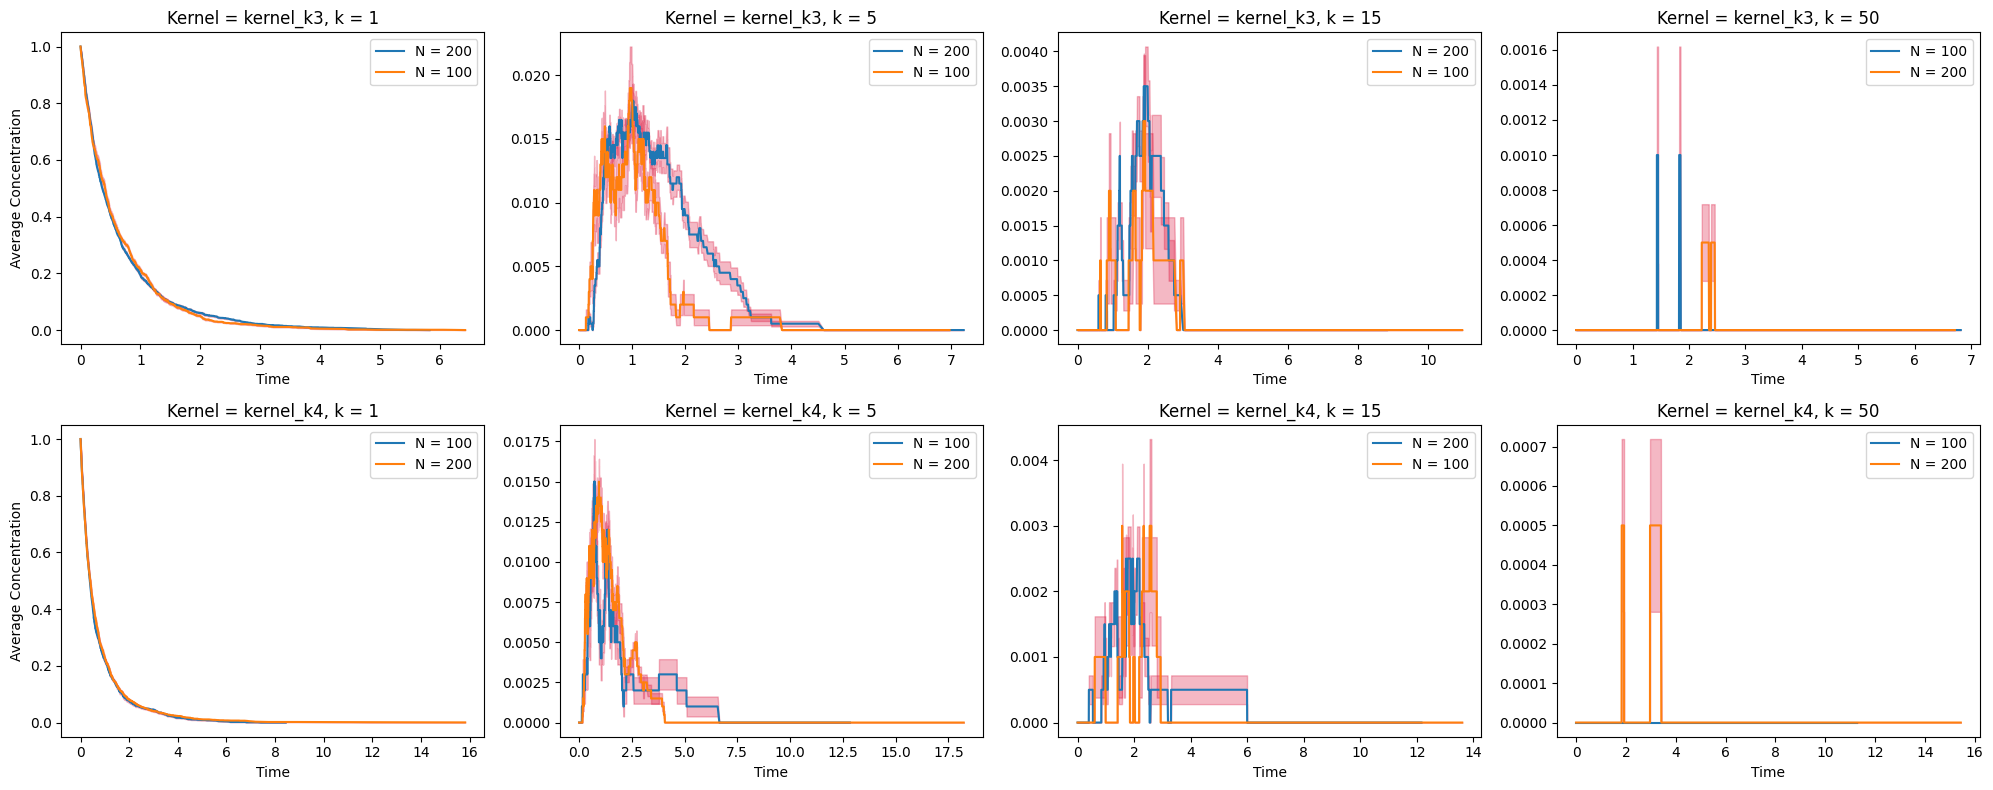

In [223]:
# Plotting concentrations
fig, axs = plt.subplots(len(kernels), len(k_values), figsize=(5 * len(k_values), 4 * len(kernels)), squeeze=False)

for row_idx, kernel in enumerate(kernels):
    for col_idx, k in enumerate(k_values):
        ax = axs[row_idx, col_idx]

        # Plot each N value in the same subplot
        for N, results in data[kernel][k]:
            ax.plot(results["J_sorted"], results["means"], label=f'N = {N}')
            ax.fill_between(results["J_sorted"], results["lower_bound"], results["upper_bound"], alpha=0.3, color = "crimson")

        ax.set_title(f'Kernel = {kernel}, k = {k}')
        ax.set_xlabel('Time')
        if col_idx == 0:
            ax.set_ylabel('Average Concentration')
        ax.legend()

plt.tight_layout()
plt.show()

### moments plots

In [247]:
import os
import pickle

results_dir = "simulation_results/moments"  # Correct directory
kernels = ["kernel_k3", "kernel_k4"]
N_values = [100, 200, 500, 1000]  # Assuming you're only interested in files with N=100

# Initialize a dictionary to store the data
data = {kernel: {N: None for N in N_values} for kernel in kernels}

# Load data from pickle files
for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        # Extracting parameters from filename
        parts = filename.replace('.pkl', '').split('_')
        # Assuming the filename structure is like 'results_N200_kernel_k3.pkl'
        N = int(parts[1][1:])  # Extract N value
        kernel = '_'.join(parts[2:])  # Reconstruct kernel name

        # Check if the N and kernel values are the ones we're interested in
        if N in N_values and kernel in kernels:
            filepath = os.path.join(results_dir, filename)
            with open(filepath, 'rb') as file:
                data[kernel][N] = pickle.load(file)
                #print(f"Loaded data for N={N}, kernel={kernel}")


Loaded data for N=100, kernel=kernel_k3
Loaded data for N=100, kernel=kernel_k4
Loaded data for N=500, kernel=kernel_k3
Loaded data for N=1000, kernel=kernel_k3
Loaded data for N=200, kernel=kernel_k4
Loaded data for N=1000, kernel=kernel_k4
Loaded data for N=500, kernel=kernel_k4
Loaded data for N=200, kernel=kernel_k3


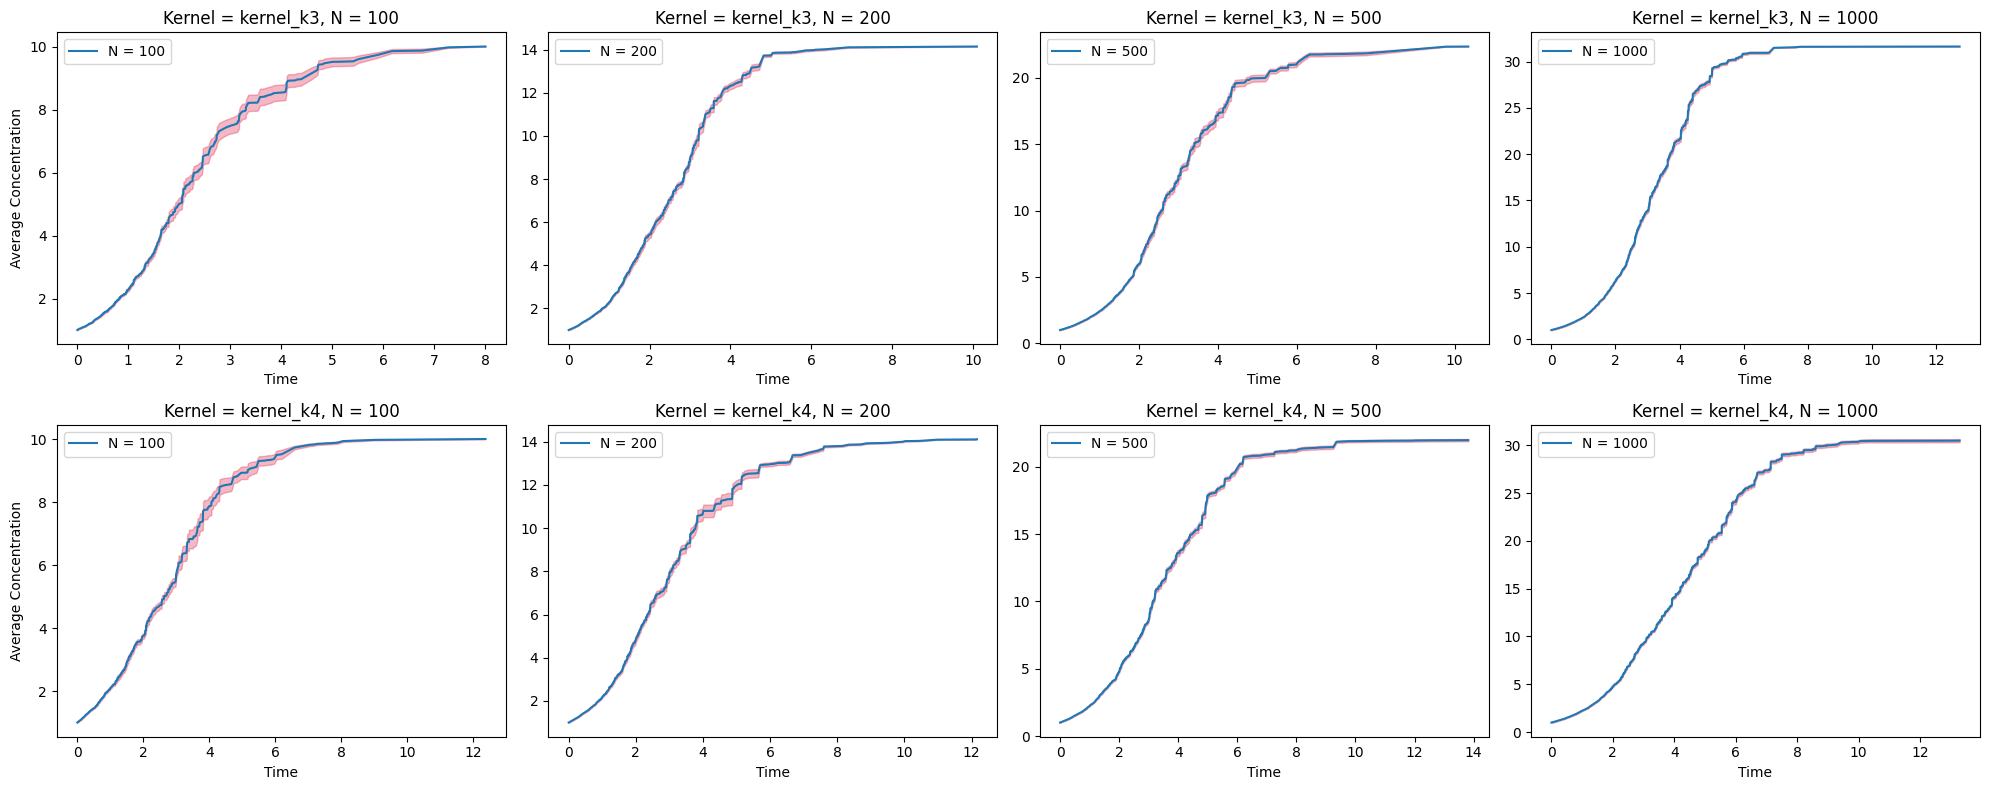

In [248]:
fig, axs = plt.subplots(len(kernels), len(N_values), figsize=(5 * len(N_values), 4 * len(kernels)), squeeze=False)

for row_idx, kernel in enumerate(kernels):
    for col_idx, N in enumerate(N_values):
        ax = axs[row_idx, col_idx]

        # Plot results for each N
        results = data[kernel][N]
        if results is not None:
            ax.plot(results["J_sorted"], results["means"], label=f'N = {N}')
            ax.fill_between(results["J_sorted"], results["lower_bound"], results["upper_bound"], alpha=0.3, color="crimson")
            # Only call legend if there's data
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

        ax.set_title(f'Kernel = {kernel}, N = {N}')
        ax.set_xlabel('Time')
        if col_idx == 0:
            ax.set_ylabel('Average Concentration')

plt.tight_layout()
plt.show()


## Part 3 output

In [ ]:
Gel1,  Gel_1sigma, J_sorted3, lower_bound3, upper_bound3 = MC_coagulation(N=N, T=10, R=10, k=50, X0 = X0, p= p, kernel='kernel_ka1', Z = "gelation")
Gel2,Gel_2sigma, J_sorted4, lower_bound4, upper_bound4 = MC_coagulation(N=N, T=10, R=10, k=50, X0 = X0, p= p, kernel='kernel_ka2', Z = "gelation")
Gel3,Gel_3sigma, J_sorted5, lower_bound5, upper_bound5 = MC_coagulation(N=N, T=10, R=10, k=50, X0 = X0, p= p, kernel='kernel_ka3', Z = "gelation")
Gel4,Gel_4sigma, J_sorted6, lower_bound6, upper_bound6 = MC_coagulation(N=N, T=10, R=10, k=50, X0 = X0, p= p, kernel='kernel_k2', Z = "gelation")

# Try optimize MC

In [ ]:
def simulate_coagulation(N, T, kernel, majorant_kernel, C):
    concentrations = {k: [] for k in [1, 5, 15, 50]}
    moments = []
    particles = np.ones(N)
    current_time = 0
    
    while current_time < T:
        # Calculate lambda hat
        lambda_hat = sum(majorant_kernel(particles[i], particles[j], C) 
                         for i in range(N) for j in range(N) if i != j) / (2*N)
        
        # Generate waiting time tau
        tau = st.expon.rvs(scale=1/lambda_hat)
        current_time += tau  # Increment current time by the waiting time
        
        # Sample a pair using AR sampling
        sampled_pairs = AR_sampling(particles, kernel, majorant_kernel, C, N=1)
        i, j = sampled_pairs[0]
       
        # With probability K(xi, xj)/K_hat(xi, xj), coagulate
        U = np.random.uniform()
        k_over_maj = kernel(particles[i], particles[j]) / majorant_kernel(particles[i], particles[j], C)
        if U <= k_over_maj:
            accepted = True
            particles[i] += particles[j]  # Merge j into i
            particles[j] = 0  # Particle j has coagulated with i, so it's set to 0
        
        for k in concentrations:
            concentrations[k].append(np.sum(particles == k) / N)
        moments.append(np.mean(particles ** 1.5))
        
        # If current time is beyond T, exit the loop
        if current_time >= T:
            break
    
        print(f"step: {current_time}, indeces: {i},{j}, accepted: {accepted}, particles: {particles}")
    return particles, concentrations, moments


final_particles, concentrations, moments = simulate_coagulation(N=10, T=1, kernel=kernel_k3, majorant_kernel=majorant_kernel, C=C)

print(final_particles)
print(concentrations, moments)

In [ ]:
import matplotlib.pyplot as plt

def plot_results(concentrations, moments, T):
    time_steps = np.linspace(0, T, len(moments))

    # Plotting average concentrations for different particle sizes
    for k in concentrations:
        plt.figure()
        plt.plot(time_steps, concentrations[k], label=f"Size {k}")
        plt.title(f"Average Concentration over Time for Particle Size {k}")
        plt.xlabel("Time")
        plt.ylabel("Concentration")
        plt.legend()
        plt.show()

    # Plotting moments
    plt.figure()
    plt.plot(time_steps, moments, label='Moment for p=1.5')
    plt.title("Moment over Time")
    plt.xlabel("Time")
    plt.ylabel("Moment")
    plt.legend()
    plt.show()

# Call this function with your data
plot_results(concentrations, moments, T=10)


In [ ]:
# Generate additional data for confidence intervals: repeat R times the simulation
Ns_all = list(range(10,10001))
Xs_all = st.uniform.rvs(loc=-1,scale=2,size=(Ns_all[-1],n))
Zs_all = [int(np.linalg.norm(x)<1) for x in Xs_all]
mean = np.mean(Zs_all[:9])
var = np.var(Zs_all[:9])
means = [] 
variances = []
true_errors = []

for N in Ns_all:
    mean_new = N/(N+1)*mean + Zs_all[N-1]/(N+1)
    var_new = (N-1)/N*var + (Zs_all[N-1]-mean)**2/(N+1)
    means.append(mean_new)
    variances.append(var_new)
    true_errors.append(abs(mean_new-I)/I)

    mean = mean_new
    var = var_new
    
    
    
# Plot the confidence intervals
plt.figure()
plt.semilogx([Ns_all[0], Ns_all[-1]], [I,I], label=r'True Mean')
plt.semilogx(Ns_all, means, label=r'Estimated Mean')
upperlim = [(m + st.norm.ppf(0.975)*np.sqrt(v/N)) for m,v,N in zip(means, variances, Ns_all)]
lowerlim = [(m - st.norm.ppf(0.975)*np.sqrt(v/N)) for m,v,N in zip(means, variances, Ns_all)]
plt.semilogx(Ns_all, upperlim,'--',color='red',label=r'Estimated $95\%$ Confidence Interval')
plt.semilogx(Ns_all, lowerlim,'--',color='red')
plt.xlabel(r'N')
plt.ylabel(r'I')
plt.legend()
plt.grid(which='both')
plt.gca().set_aspect(3.0)
plt.show()

# Part 4

In [ ]:
import numpy as np
import scipy.stats as st

def generate_path(N, T, kernel, C):
    # This function should generate one path of the Markov process 
    # using the kernel and return the path and the associated time to coagulation.
    # Implement this function based on your specific Markov process.
    pass

def weightfun(Q, Q_hat, path):
    # Q: original transition rate matrix
    # Q_hat: modified transition rate matrix used for importance sampling
    # path: the sequence of states in the Markov chain
    weights = []
    for i in range(1, len(path)):
        q_original = Q[path[i-1], path[i]]
        q_hat = Q_hat[path[i-1], path[i]]
        weights.append(q_original / q_hat if q_hat > 0 else 0)
    
    # Compute the product of weights along the path
    likelihood_ratio = np.prod(weights)
    return likelihood_ratio

def importance_sampling(N, T, kernel, Q, Q_hat, C, num_samples):
    samples = []
    weights = []

    for _ in range(num_samples):
        path = generate_path(N, T, kernel, C)
        weight = weightfun(path, Q, Q_hat)
        samples.append(path)
        weights.append(weight)

    # Use the weighted samples to compute expectations
    weighted_samples = [w * s for w, s in zip(weights, samples)]
    expectation = np.mean(weighted_samples)

    return expectation, samples, weights

# Run the importance sampling simulation
expectation, samples, weights = importance_sampling(
    N=100, T=10, kernel=kernel_k3, Q=Q, Q_hat=Q_hat, C=C, num_samples=1000
)

# Now you can use 'expectation' for further analysis
